# Wstęp

Metody uczenia maszynowego możemy podzielić na dwie główne kategorie (pomijając uczenie ze wzmocnieniem): nadzorowane i nienadzorowane. Uczenie **nadzorowane** (ang. *supervised*) to jest uczenie z dostępnymi etykietami dla danych wejściowych. Na parach danych uczących $dataset= \{(x_0,y_0), (x_1,y_1), \ldots, (x_n,y_n)\}$ model ma za zadanie nauczyć się funkcji $f: X \rightarrow Y$. Z kolei modele uczone w sposób **nienadzorowany** (ang. *unsupervised*) wykorzystują podczas trenowania dane nieetykietowane tzn. nie znamy $y$ z pary $(x, y)$.

Dość częstą sytuacją, z jaką mamy do czynienia, jest posiadanie małego podziobioru danych etykietowanych i dużego nieetykietowanych. Często annotacja danych wymaga ingerencji człowieka - ktoś musi określić co jest na obrazku, ktoś musi powiedzieć czy dane słowo jest rzeczownkiem czy czasownikiem itd. 

Jeżeli mamy dane etykietowane do zadania uczenia nadzorowanego (np. klasyfikacja obrazka), ale także dużą ilość danych nieetykietowanych, to możemy wtedy zastosować techniki **uczenia częściowo nadzorowanego** (ang. *semi-supervised learning*). Te techniki najczęściej uczą się funkcji $f: X \rightarrow Y$, ale jednocześnie są w stanie wykorzystać informacje z danych nieetykietowanych do poprawienia działania modelu.

## Cel ćwiczenia

Celem ćwiczenia jest nauczenie modelu z wykorzystaniem danych etykietowanych i nieetykietowanych ze zbioru STL10 z użyciem metody [Bootstrap your own latent](https://arxiv.org/abs/2006.07733).

Metoda ta jest relatywnie "lekka" obliczeniowo, a także dość prosta do zrozumienia i zaimplementowania, dlatego też na niej się skupimy na tych laboratoriach.

# Zbiór STL10

Zbiór STL10 to zbiór stworzony i udostępniony przez Stanford [[strona]](https://ai.stanford.edu/~acoates/stl10/) [[papier]](https://cs.stanford.edu/~acoates/papers/coatesleeng_aistats_2011.pdf) a inspirowany przez CIFAR-10. Obrazy zostały pozyskane z [ImageNet](https://image-net.org/). Szczegóły można doczytać na ich stronie. To co jest ważne to to, że autorzy zbioru dostarczają predefiniowany plan eksperymentalny, żeby móc porównywać łatwo wyniki eksperymentów. Nie będziemy go tutaj stosować z uwagi na jego czasochłonność (10 foldów), ale warto pamiętać o tym, że często są z góry ustalone sposoby walidacji zaprojetowanych przez nas algorytmów na określonych zbiorach referencyjnych.

Korzystając z `torchvision.datasets` ***załaduj*** 3 podziały zbioru danych STL10: `train`, `test`, `unlabeled` oraz utwórz z nich instancje klasy `DataLoader`. Korzystając z Google Colab rozważ użycie Google Drive do przechowyania zbioru w calu zaoszczędzenia czasu na wielokrotne pobieranie.

LABELS: 
0. airplane
1. bird
2. car
3. cat
4. deer
5. dog
6. horse
7. monkey
8. ship
9. truck

In [1]:
import torch
import torchvision
import torch.nn as nn
from tqdm import tqdm
from typing import Tuple
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
batch_size = 32

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

train_data = datasets.STL10(root='.', split='train', download=True, transform=transform_train)
test_data = datasets.STL10(root='.', split='test', download=True, transform=transform_test)
unlabeled_data = datasets.STL10(root='.', split='unlabeled', download=True, transform=transform_train)

train_loader = DataLoader(train_data, batch_size=batch_size, pin_memory=True, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, pin_memory=True)
unlabeled_loader = DataLoader(unlabeled_data, batch_size=batch_size, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


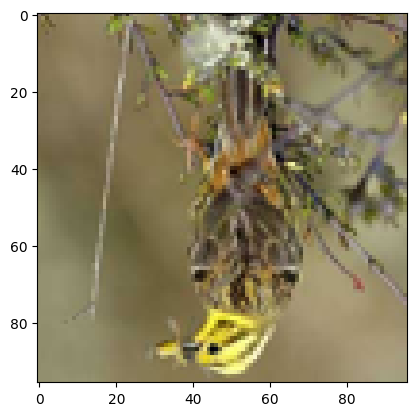

1


In [3]:
from matplotlib import pyplot as plt

image, label = train_data[0]
plt.imshow(image.permute(1,2,0))
plt.show()
label = train_data.labels[0]
print(label)

# Uczenie nadzorowane

Żeby porównać czy metoda BYOL przynosi nam jakieś korzyści musimy wyznaczyć wartość bazową metryk(i) jakości, których będziemu używać (np. dokładność).

***Zaimplementuj*** wybraną metodę uczenia nadzorowanego na danych `train` z STL10. Możesz wykorzystać predefiniowane architektury w `torchvision.models` oraz kody źródłowe z poprzednich list.

In [4]:
def count_correct(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    preds = torch.argmax(y_pred, dim=1)
    return (preds == y_true).float().sum()


def validate(
    model: nn.Module, 
    loss_fn: torch.nn.CrossEntropyLoss, 
    dataloader: DataLoader
) -> Tuple[torch.Tensor, torch.Tensor]:
    loss = 0
    correct = 0
    all = 0
    for X_batch, y_batch in dataloader:
        y_pred = model(X_batch.cuda())
        all += 1
        loss += loss_fn(y_pred, y_batch.cuda()).sum()
        correct += count_correct(y_pred, y_batch.cuda())
    return loss / all, correct / all


def calculate_loss_and_optimize(
    model: nn.Module, 
    optimizer: optim.Optimizer, 
    loss_fn: torch.nn.CrossEntropyLoss, 
    X_batch, 
    y_batch
):
    y_pred = model(X_batch.cuda())
    loss = loss_fn(y_pred, y_batch.cuda())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
def print_metrics(epoch, train_loss, train_acc, val_loss, val_acc):
    print(
        f"Epoch {epoch}: "
        f"train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
        f"validation loss = {val_loss:.3f} (acc: {val_acc:.3f})"
    )

def fit(
    model: nn.Module, 
    optimiser: optim.Optimizer, 
    loss_fn: torch.nn.CrossEntropyLoss, 
    train_dl: DataLoader, 
    val_dl: DataLoader, 
    epochs: int, 
    print_metrics_flag: bool = True
):
    val_losses = []
    val_accs = []
    
    for epoch in range(epochs):
        for X_batch, y_batch in train_dl:
            calculate_loss_and_optimize(model, optimiser, loss_fn, X_batch, y_batch)

        if print_metrics_flag: 
            model.eval()
            with torch.no_grad():
                train_loss, train_acc = validate(
                    model=model, loss_fn=loss_fn, dataloader=train_dl
                ) 
                val_loss, val_acc = validate(
                    model=model, loss_fn=loss_fn, dataloader=val_dl
                )
                val_accs.append(val_acc)
                val_losses.append(val_loss)
                print_metrics(epoch, train_loss, train_acc, val_loss, val_acc)
    return val_losses, val_accs

In [5]:
class CustomResNet18(torch.nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = self.features(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [86]:
model = CustomResNet18().cuda()

loss = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

val_losses_Simple, val_accs_Simple = fit(model, optimizer, loss, train_loader, test_loader, 50, True)

Epoch 0: train loss = 1.022 (acc: 20.096), validation loss = 1.103 (acc: 19.348)
Epoch 1: train loss = 2.244 (acc: 4.178), validation loss = 2.239 (acc: 4.484)
Epoch 2: train loss = 1.908 (acc: 5.745), validation loss = 1.924 (acc: 5.648)
Epoch 3: train loss = 1.764 (acc: 8.599), validation loss = 1.776 (acc: 8.376)
Epoch 4: train loss = 1.585 (acc: 11.981), validation loss = 1.600 (acc: 11.388)
Epoch 5: train loss = 1.593 (acc: 12.210), validation loss = 1.615 (acc: 11.848)
Epoch 6: train loss = 1.529 (acc: 12.478), validation loss = 1.538 (acc: 12.556)
Epoch 7: train loss = 1.441 (acc: 14.694), validation loss = 1.465 (acc: 14.128)
Epoch 8: train loss = 1.332 (acc: 15.280), validation loss = 1.389 (acc: 14.876)
Epoch 9: train loss = 1.371 (acc: 14.847), validation loss = 1.425 (acc: 14.020)
Epoch 10: train loss = 1.192 (acc: 17.637), validation loss = 1.280 (acc: 16.924)
Epoch 11: train loss = 1.017 (acc: 19.688), validation loss = 1.152 (acc: 18.160)
Epoch 12: train loss = 0.911 (ac

# Bootstrap your own latent

Metoda [Bootstrap your own latent](https://arxiv.org/abs/2006.07733) jest opisana w rodziale 3.1 papieru a także w dodatku A. Składa się z dwóch etapów:


1.   uczenia samonadzorowanego (ang. *self-supervised*)
2.   douczania nadzorowanego (ang. *fine-tuning*)

## Uczenie samonadzorowane

Architektura do nauczania samonadzorowanego składa się z dwóch sieci: (1) *online* i (2) *target*. W uproszczeniu cała architektura działa tak:


1.   Dla obrazka $x$ wygeneruj dwie różne augmentacje $v$ i $v'$ za pomocą funkcji $t$ i $t'$.
2.   Widok $v$ przekazujemy do sieci *online*, a $v'$ do *target*.
3.   Następnie widoki przekształacamy za pomocą sieci do uczenia reprezentacji (np. resnet18 lub resnet50) do reprezentacji $y_\theta$ i $y'_\xi$.
4.   Potem dokonujemy projekcji tych reprezentacji w celu zmniejszenia wymiarowości (np. za pomocą sieci MLP).
5.   Na sieci online dokonujmey dodatkowo predykcji pseudo-etykiety (ang. *pseudolabel*)
6.   Wyliczamy fukncję kosztu: MSE z wyjścia predyktora sieci *online* oraz wyjścia projekcji sieci *target* "przepuszczonej" przez predyktor sieci *online* **bez propagacji wstecznej** (*vide Algorithm 1* z papieru).
7.   Dokonujemy wstecznej propagacji **tylko** po sieci *online*.
8.   Aktualizujemy wagi sieci *target* sumując w ważony sposób wagi obu sieci $\xi = \tau\xi + (1 - \tau)\theta$ ($\tau$ jest hiperprametrem) - jest to ruchoma średnia wykładnicza (ang. *moving exponential average*).

Po zakończeniu procesu uczenia samonadzorowanego zostawiamy do douczania sieć kodera *online* $f_\theta$. Cała sieć *target* oraz warstwy do projekcji i predykcji w sieci *online* są "do wyrzucenia".



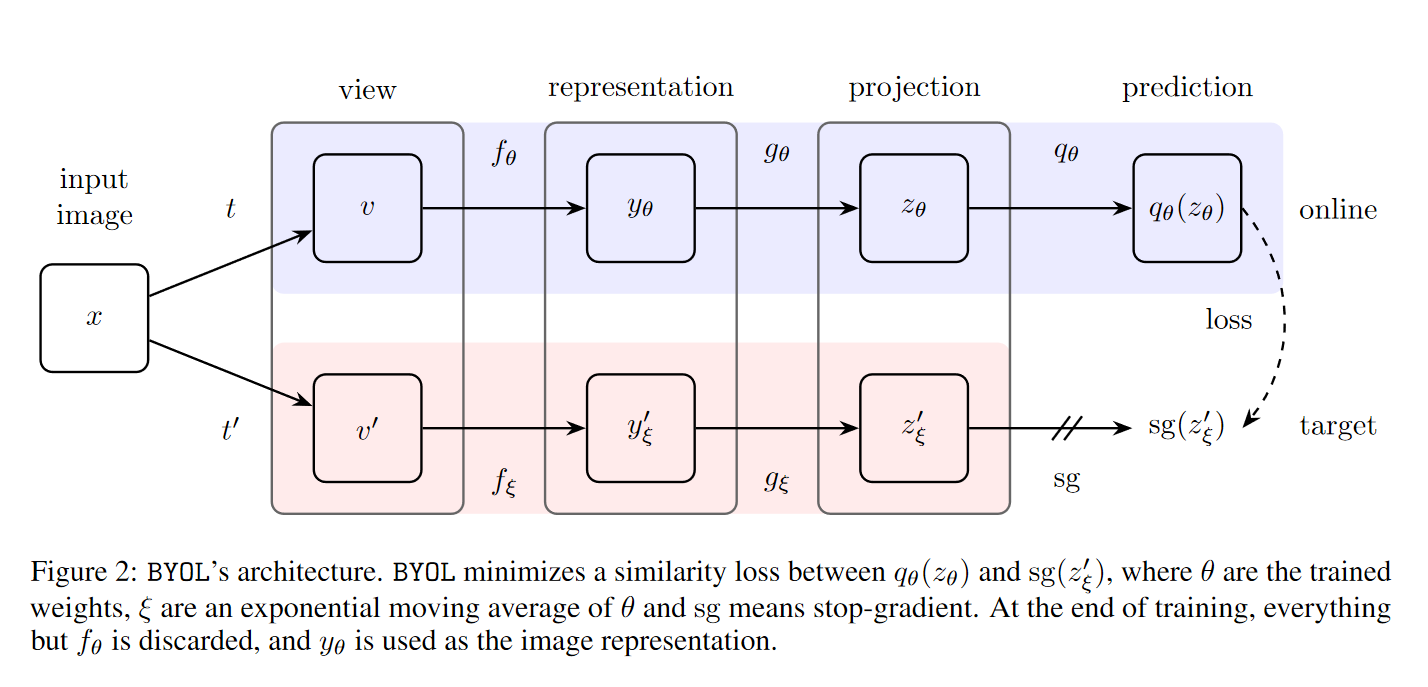

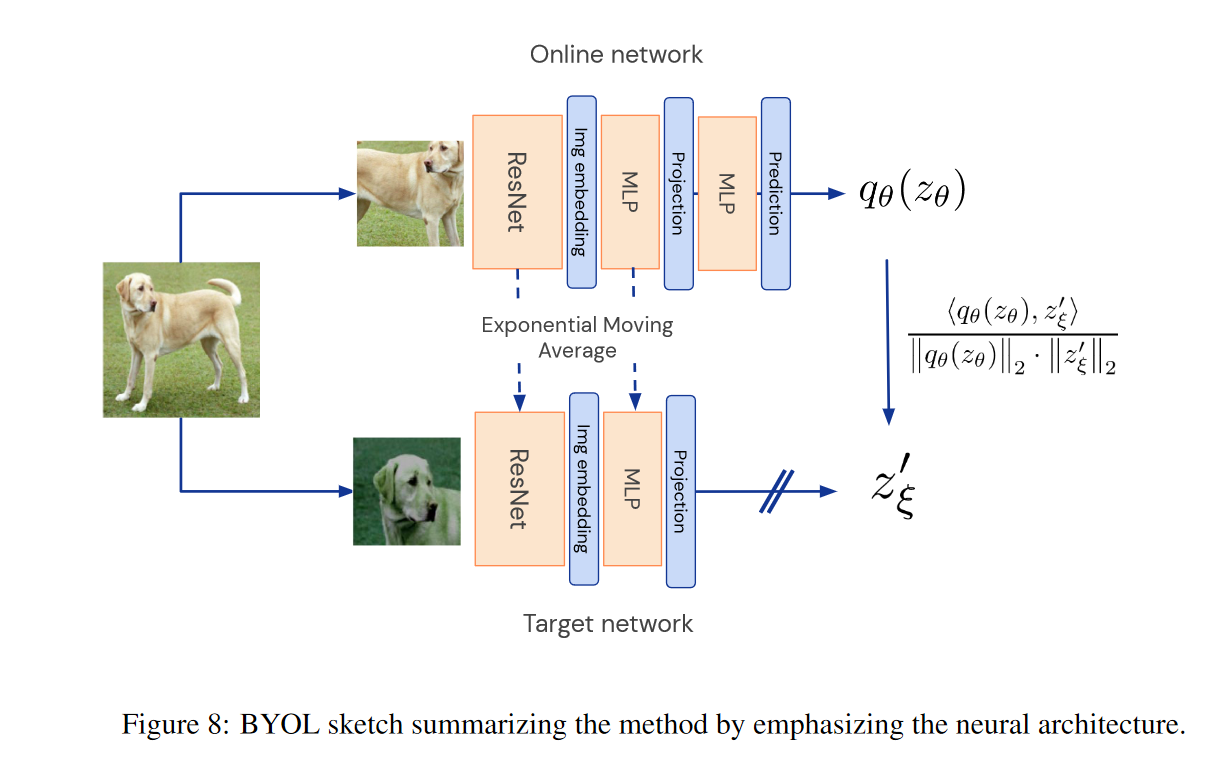

### Augmentacja

Dodatek B publikacji opisuje augmentacje zastosowane w metodzie BYOL. Zwróć uwagę na tabelę 6 w publikacji. `torchvision.transforms.RandomApply` może być pomocne. 

***Zaimeplementuj*** augmentację $\tau$ i $\tau'$.


In [6]:
import torchvision.transforms as T

transform_T = T.Compose([
    T.RandomResizedCrop(size=224, scale=(0.08, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomApply([T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)], p=0.8),
    T.RandomApply([T.GaussianBlur(kernel_size=23, sigma=(0.1, 2.0))], p=0.1),
    T.ToTensor(),
])

transform_TPrime = T.Compose([
    T.RandomResizedCrop(size=224, scale=(0.08, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomApply([T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)], p=0.8),
    T.RandomApply([T.GaussianBlur(kernel_size=23, sigma=(0.1, 2.0))], p=0.1),
    T.ToTensor(),
])

### Implementacja uczenia samonadzorowanego

***Zaprogramuj*** proces uczenia samonadzorowanego na danych nieetykietowanych ze zbioru STL10.

Wskazówki do realizacji polecenia:

1. Proces uczenia może trwać bardzo długo dlatego zaleca się zastsowanie wczesnego zatrzymania lub uczenia przez tylko jedną epokę. Mimo wszystko powinno się dać osiągnąć poprawę w uczeniu nadzorowanym wykorzystując tylko zasoby z Google Colab.
2. Dobrze jest pominąć walidację na zbiorze treningowym i robić ją tylko na zbiorze walidacyjnym - zbiór treningowy jest ogromny i w związku z tym narzut czasowy na walidację też będzie duży.
3. Walidację modelu można przeprowadzić na zbiorze `train` lub całkowicie ją pominąć, jeżeli uczymy na stałej ilości epok.
4. Rozważ zastosowanie tylko jednej augmentacji - augmentacja $\tau'$ jest bardziej czasochłonna niż $\tau$.
5. Poniżej jest zaprezentowany zalążek kodu - jest on jedynie wskazówką i można na swój sposób zaimplementować tę metodę

In [8]:
from copy import deepcopy
from torch import nn
from torchvision.transforms import ToPILImage


class EncoderCustomResNet18(torch.nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.features(x)
        x = self.avg_pool(x)
        return x.view(x.size(0), -1)


class BYOL(nn.Module):
    def __init__(self, model, augmentation, augmentation_prim, encoder_out_shape=1000, projection_size=256, tau=0.99):
        super().__init__()

        self.encoder_online = model
        self.projector_online = nn.Sequential(
            nn.Linear(encoder_out_shape, projection_size),
            nn.BatchNorm1d(projection_size),
            nn.ReLU(inplace=True),
            nn.Linear(projection_size, projection_size),
            nn.BatchNorm1d(projection_size),
        )
        self.online_head = nn.Linear(projection_size, projection_size)
        self.online_network = nn.Sequential(self.encoder_online, self.projector_online)

        self.encoder_target = deepcopy(self.encoder_online)
        self.projector_target = deepcopy(self.projector_online)
        self.target_network = nn.Sequential(self.encoder_target, self.projector_target)

        self.tau = tau
        self.augmentation = augmentation
        self.augmentation_prim = augmentation_prim

    def forward(self, x: torch.Tensor):
        to_pil = torchvision.transforms.ToPILImage()

        view_1 = torch.stack([self.augmentation(to_pil(img)) for img in x]).cuda()
        view_2 = torch.stack([self.augmentation_prim(to_pil(img)) for img in x]).cuda()

        z_online = self.online_network(view_1)
        with torch.no_grad():
            z_target = self.target_network(view_2)

        p_online = self.online_head(z_online)

        z_online = F.normalize(z_online, dim=-1)
        z_target = F.normalize(z_target, dim=-1)
        p_online = F.normalize(p_online, dim=-1)

        loss = 2 - 2 * (p_online * z_target.detach()).sum(dim=-1).mean()

        return loss

    def update_target_network(self):
        for online, target in zip(self.online_network.parameters(), self.target_network.parameters()):
            target.data = self.tau * target.data + (1 - self.tau) * online.data


In [36]:
base_model = EncoderCustomResNet18().cuda()
model = BYOL(
    model=base_model, 
    augmentation=transform_T,
    augmentation_prim=transform_TPrime, 
    encoder_out_shape=512,
    projection_size=256,
    tau=0.99
).cuda()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for epoch in range(1):
    with tqdm(total=len(unlabeled_loader)) as progress_bar:
        for i, (X_batch, _) in enumerate(unlabeled_loader):
            loss = model(X_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            model.update_target_network()
            progress_bar.set_description(f'Epoch [{epoch+1}]')
            progress_bar.update(1)
            
    test_loss = 0.0
    model.eval()
    with torch.no_grad():
        with tqdm(total=len(test_loader)) as progress_bar:
            i = 1
            for X_batch, Y_batch in test_loader:
                loss = model(X_batch)
                test_loss += loss.item()
                progress_bar.set_description(f'Validation loss: {(test_loss / i):4f}')
                i += 1
                progress_bar.update(1)
    print(f"LOSS: {test_loss / len(test_loader)}")

c:\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Validation loss: 0.249110: 100%|██████████| 250/250 [01:56<00:00,  2.15it/s]

LOSS: 0.24910982418060304


## Douczanie nadzorowane

***Zaimplementuj*** proces douczania kodera z poprzedniego polecenia na danych etykietowanych ze zbioru treningowego. Porównaj jakość tego modelu z modelem nauczonym tylko na danych etykietownaych. Postaraj się wyjaśnić różnice.

In [38]:
class CustomEncoder(torch.nn.Module):
    def __init__(self, pretrained_encoder):
        super().__init__()
        self.features = pretrained_encoder
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = self.features(x)
        return self.fc(x)

state_dict = model.encoder_online.state_dict()
encoder = EncoderCustomResNet18().cuda()
encoder.load_state_dict(state_dict)
new_model = CustomEncoder(encoder).cuda()
optimizer = optim.Adam(new_model.parameters())
loss = torch.nn.CrossEntropyLoss()

val_losses_coder, val_accs_coder = fit(new_model, optimizer, loss, train_loader, test_loader, 50, True)

Epoch 0: train loss = 1.898 (acc: 14.605), validation loss = 1.998 (acc: 14.360)
Epoch 1: train loss = 2.302 (acc: 3.185), validation loss = 2.302 (acc: 3.200)
Epoch 2: train loss = 2.126 (acc: 5.197), validation loss = 2.134 (acc: 4.952)
Epoch 3: train loss = 1.769 (acc: 9.159), validation loss = 1.790 (acc: 8.844)
Epoch 4: train loss = 1.639 (acc: 10.650), validation loss = 1.642 (acc: 10.776)
Epoch 5: train loss = 1.651 (acc: 10.949), validation loss = 1.680 (acc: 10.936)
Epoch 6: train loss = 1.517 (acc: 12.624), validation loss = 1.543 (acc: 12.292)
Epoch 7: train loss = 1.470 (acc: 13.369), validation loss = 1.489 (acc: 12.692)
Epoch 8: train loss = 1.455 (acc: 13.752), validation loss = 1.490 (acc: 13.544)
Epoch 9: train loss = 1.474 (acc: 13.624), validation loss = 1.528 (acc: 13.108)
Epoch 10: train loss = 1.274 (acc: 16.592), validation loss = 1.347 (acc: 15.484)
Epoch 11: train loss = 1.236 (acc: 16.917), validation loss = 1.325 (acc: 15.908)
Epoch 12: train loss = 1.147 (ac

Uczenie z nadzorem polega na trenowaniu modelu, aby przewidywał poprawną etykietę dla danego wejścia. Natomiast podejścia samo-nadzorujące takie jak BYOL mają na celu nauczenie modelu tworzenia użytecznej reprezentacji danych wejściowych bez wykorzystywania jawnego nadzoru. To osiągane jest poprzez trenowanie modelu do przewidywania jakiegoś aspektu danych wejściowych, który nie jest etykietą, na przykład przewidywanie przetworzonej wersji danych wejściowych.

W ogólnym przypadku, uczenie z nadzorem ma większą szansę na osiągnięcie lepszych wyników niż podejścia samo-nadzorujące, jeśli dostępna jest duża ilość etykietowanych danych, a rozkład danych jest dobrze dopasowany do przestrzeni etykiet. Dzieje się tak, ponieważ model może bezpośrednio optymalizować na rzecz zadania i nauczyć się wykorzystywać informacje z etykiet do poprawy swoich predykcji.